### Imports

In [50]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning
from pandas import to_datetime
import statsmodels.api as sm
from statsmodels import regression
from sklearn.linear_model import LinearRegression


warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [51]:
buy_sell_threshold = 0.2
investment_ratio = 0.00005
long_short_ratio = 0.2
price_cap_lower = 0.5
stop_loss = 0.1
starting_balance = 1000000

run_optimizing = False
google_colab = False

### Data loading

In [52]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "1PZQLyOiOpKtLt5BVAvWwQEnxZJzvLcD7"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('Full trading data - All models.csv')  
    df = pd.read_csv('Full trading data - All models.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/trading/Full trading data - All models.csv')

### Data processing

In [53]:
# Drop Expire_date column
df.drop('Expire_date', axis=1, inplace=True)

In [54]:
# Filter so its just data for 2015
#df = df[(df["Quote_date"] >= "2015-01-01") & (df["Quote_date"] <= "2018-12-31")]
#df = df[(df["Expiry_date"] >= "2015-01-01") & (df["Expiry_date"] <= "2018-12-31")]

# Choos 5% of the data randomly
#df = df.sample(frac=0.02, random_state=1)

In [55]:
lstm_mlp = True
bs_rolling = False
bs_garch = False
bs_iv = False
heston = False

if lstm_mlp:
    # Out of Quote_date	Expire_date	Price	Bid	Ask	Underlying_last	Strike	TTM	Delta	IV	R	Price_drop	Rolling	GARCH	BS-IV	Heston	LSTM-MLP, drop Rolling, GARCH, BS-IV, Heston
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'LSTM-MLP']]
    # Rename LSTM-MLP to Prediction
    df = df.rename(columns={'LSTM-MLP': 'Prediction'})
elif bs_rolling:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Rolling']]
    df = df.rename(columns={'Rolling': 'Prediction'})
elif bs_garch:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'GARCH']]
    df = df.rename(columns={'GARCH': 'Prediction'})
elif bs_iv:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'BS-IV']]
    df = df.rename(columns={'BS-IV': 'Prediction'})
elif heston:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Heston']]
    df = df.rename(columns={'Heston': 'Prediction'})

In [56]:
print(len(df))

175188


# Trading functions

In [57]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] - df['Ask']) / df['Ask'] >= buy_threshold
    sell_signal = (df['Bid'] - df['Prediction']) / df['Bid'] >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio = 0.002, long_short_ratio= 0.02, fee = 0.001, stop_loss = 0.2):
    df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])
    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    df = df[df['Expiry_date'] <= df['Quote_date'].max()]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1

    df['Position_this_opt'] = 0
    df['Balance'] = -1000000    # Makes it easy to spot if balance has not been updated correctly

    df = df.sort_values('Quote_date')
    df['Option_ID'] = df['Option_ID'].astype(str)

    position_dict = {id:0 for id in df['Option_ID'].unique()}
    first_date = df['Quote_date'].min()
    total_balance_dict = {first_date: starting_balance}

    number_of_long_positions = 0
    number_of_short_positions = 0
    entry_prices = {}

    def operation(row):
        nonlocal number_of_long_positions
        nonlocal number_of_short_positions
        if row['Quote_date'] not in total_balance_dict.keys():
            total_balance_dict[row['Quote_date']] = total_balance_dict[max(total_balance_dict.keys())]

        balance = total_balance_dict[row['Quote_date']]
        position = position_dict[row['Option_ID']]

        # If price below cap, do nothing
        if row["Price"] < price_cap_lower:
            row["Position_this_opt"] = position
            row["Balance"] = balance
            position_dict[row['Option_ID']] = position
            total_balance_dict[row['Quote_date']] = balance
            return row

        # Calculate net ratio
        if number_of_long_positions + number_of_short_positions == 0:
            net_ratio = 0
        else:
            net_ratio = (number_of_long_positions - number_of_short_positions) / (number_of_long_positions + number_of_short_positions)

        # Buy 
        if row['Signal'] == 1 and position <= 0 and row["Quote_date"] != row["Expiry_date"] and balance > 100 and net_ratio < long_short_ratio:
            amount_to_invest = balance * investment_ratio
            if amount_to_invest <= balance:
                balance -= amount_to_invest * (1 + fee)
                position += amount_to_invest / row['Ask']
                number_of_long_positions += 1
                entry_prices[row['Option_ID']] = row['Ask']

        # Sell
        elif row['Signal'] == -1 and position >= 0 and row["Quote_date"] != row["Expiry_date"] and balance > 100 and net_ratio > -long_short_ratio:
            amount_to_sell = balance * investment_ratio
            balance += amount_to_sell * (1 - fee)
            position -= amount_to_sell / row['Bid']
            number_of_short_positions += 1
            entry_prices[row['Option_ID']] = row['Bid']

        # Check if the stop-loss should be triggered
        if row['Option_ID'] in entry_prices:
            entry_price = entry_prices[row['Option_ID']]
            current_price = row['Ask'] if position > 0 else row['Bid']
            # Long
            if position > 0 and (entry_price - current_price) / entry_price >= stop_loss:
                balance += position * current_price * (1 - fee)
                position = 0
                number_of_long_positions -= 1
                del entry_prices[row['Option_ID']]
            # Short
            elif position < 0 and (current_price - entry_price) / entry_price >= stop_loss:
                balance -= position * current_price * (1 + fee)
                position = 0
                number_of_short_positions -= 1
                del entry_prices[row['Option_ID']]

        # Expire
        elif row["Quote_date"] == row["Expiry_date"] and position != 0:
            intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
            adjustment = intrinsic_value if position > 0 else -intrinsic_value
            balance += adjustment * abs(position)
            position = 0
            if position < 0:
                number_of_short_positions -= 1
            elif position > 0:
                number_of_long_positions -= 1
        
        
        row['Position_this_opt'] = position
        position_dict[row['Option_ID']] = position
        total_balance_dict[row['Quote_date']] = balance
        row['Balance'] = balance
        return row

    df = df.apply(operation, axis=1)
    df.loc[(df['Position_this_opt'] == 0), 'Balance'] = df['Quote_date'].map(total_balance_dict)
    return df

def calculate_options_value(df):
    df['Options_value'] = 0
    for date in df['Quote_date'].unique():
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Analysis functions

In [58]:
def sharpe_ratio(df):
    df_sharpe = df.copy()
    # Make dataframe with 1M risk free rate
    df_rf = df_sharpe.loc[(df_sharpe["TTM"] >= 28) & (df_sharpe["TTM"] <= 32)]  # Get the rows with TTM close to one month
    df_rf = df_rf.groupby('Quote_date').last()["R"]

    # Original dataframe
    df_group = df.groupby('Quote_date').last()
    df_group["Returns"] = df_group["Total_value"].pct_change()

    # Excess returns
    df_group["Excess_Returns"] = df_group["Returns"] - df_rf / 252
    
    # Sharpe ratio
    sharpe_ratio = np.sqrt(252) * (df_group["Excess_Returns"].mean() / df_group["Excess_Returns"].std())

    return sharpe_ratio

In [59]:
def sharpe_ratio_monthly(df):
    df_sharpe = df.copy()
    df_sharpe["YYYY-MM"] = df_sharpe["Quote_date"].dt.strftime("%Y-%m")
    
    # Find the risk-free rate for each month from a row with the same YYYY-MM and TTM close to one month
    df_rf = df_sharpe.loc[(df_sharpe["TTM"] >= 28) & (df_sharpe["TTM"] <= 32)]  # Get the rows with TTM close to one month
    df_rf = df_rf.groupby("YYYY-MM").last()["R"]
    
    df_sharpe = df_sharpe.groupby("YYYY-MM").last()
    df_sharpe["Returns"] = df_sharpe["Total_value"].pct_change()
    
    df_sharpe["Excess_Returns"] = df_sharpe["Returns"] - df_rf / 12
    sharpe_ratio = np.sqrt(12) * (df_sharpe["Excess_Returns"].mean() / df_sharpe["Excess_Returns"].std())
    
    return sharpe_ratio

In [60]:
def sortino_ratio(df):
    df_sharpe = df.copy()
    # Make dataframe with 1M risk free rate
    
    df_rf = df_sharpe.loc[(df_sharpe["TTM"] >= 28) & (df_sharpe["TTM"] <= 32)]  # Get the rows with TTM close to one month
    df_rf = df_rf.groupby('Quote_date').last()["R"]

    df_group = df.groupby('Quote_date').last()
    df_group['Excess_Returns'] = df_group['Total_value'].pct_change() - df_rf / 252

    sortino_ratio = np.sqrt(252) * (df_group["Excess_Returns"].mean() / df_group.loc[df_group["Excess_Returns"] < 0, "Excess_Returns"].std())
    return sortino_ratio

In [61]:
def capm_alpha(df_capm):
    # Find alpha in the CAPM model using linear regression and grouping df by Quote_date, then taking the alpha of Total_value compared to Underlying_last which is the S&P500
    df_capm = df_capm.groupby('Quote_date').last()
    df_capm = df_capm[['Total_value', 'Underlying_last']]
    df_capm = df_capm.dropna()
    df_capm['Underlying_last'] = df_capm['Underlying_last'].pct_change()
    df_capm['Total_value'] = df_capm['Total_value'].pct_change()
    df_capm = df_capm.dropna()
    df_capm = df_capm.reset_index()
    df_capm = df_capm.drop(columns=['Quote_date'])
    df_capm = df_capm.dropna()
    X = df_capm['Underlying_last'].values.reshape(-1, 1)
    y = df_capm['Total_value'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    return reg.intercept_[0] * 252

In [62]:
def capm_beta(df_capm):
    # Find beta in the CAPM model using linear regression and grouping df by Quote_date, then taking the beta of Total_value compared to Underlying_last which is the S&P500
    df_capm = df_capm.groupby('Quote_date').last()
    df_capm = df_capm[['Total_value', 'Underlying_last']]
    df_capm = df_capm.dropna()
    df_capm['Underlying_last'] = df_capm['Underlying_last'].pct_change()
    df_capm['Total_value'] = df_capm['Total_value'].pct_change()
    df_capm = df_capm.dropna()
    df_capm = df_capm.reset_index()
    df_capm = df_capm.drop(columns=['Quote_date'])
    df_capm = df_capm.dropna()
    X = df_capm['Underlying_last'].values.reshape(-1, 1)
    y = df_capm['Total_value'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    return reg.coef_[0][0] * 252

In [63]:
def max_drawdown(df):
    df_group = df.groupby('Quote_date').last()
    df_group['Roll_Max'] = df_group['Total_value'].cummax()
    df_group['Drawdown'] = df_group['Total_value'] / df_group['Roll_Max'] - 1.0
    df_group['Drawdown'].min()
    return df_group['Drawdown'].min() * 100

In [64]:
def print_results(df, starting_balance):
    ending_balance = df['Balance'].iloc[-1]
    profit = ending_balance - starting_balance
    num_trades = df[df["Price"] > 1]["Signal"].abs().sum()
    profit_per_trade = profit / num_trades

    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    trading_days = df['Quote_date'].unique().shape[0] - 1
    profit_per_day = profit / trading_days
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days

    annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

    print(f"Starting balance: {starting_balance}")
    print(f"Ending balance: {ending_balance.round(0)}")
    print(f"Profit: {profit.round(0)}")
    print(f"Profit per trade: {profit_per_trade.round(2)}")
    print(f"Profit per trading day: {profit_per_day.round(2)}")
    print(f"Sharpe ratio: {sharpe_ratio_monthly(df).round(2)}")
    print(f"CAPM alpha: {capm_alpha(df).round(2)}")
    print(f"Annualized return in percent: {annualized_return.round(2)}")
    print(f"Max drawdown: {max_drawdown(df).round(2)}")

In [65]:
def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Cash')
    plt.plot(df['Options_value'], label='Net value of options')
    plt.title('Portfolio value over time')
    # Make plot smaller
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## Run the code

Run by year

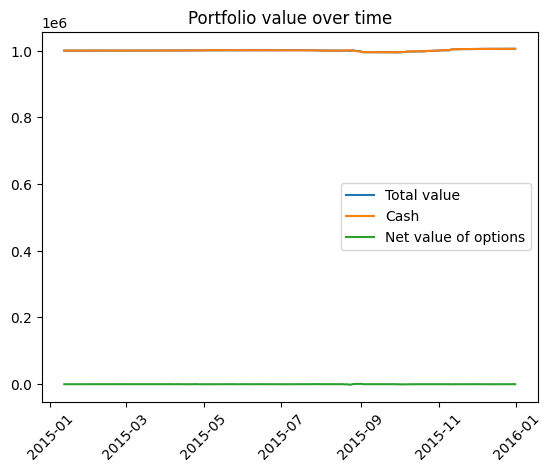

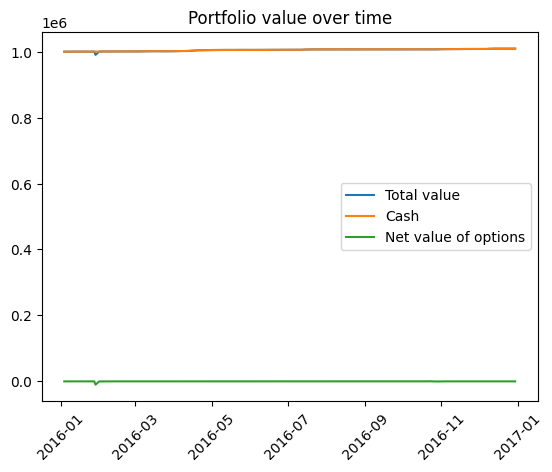

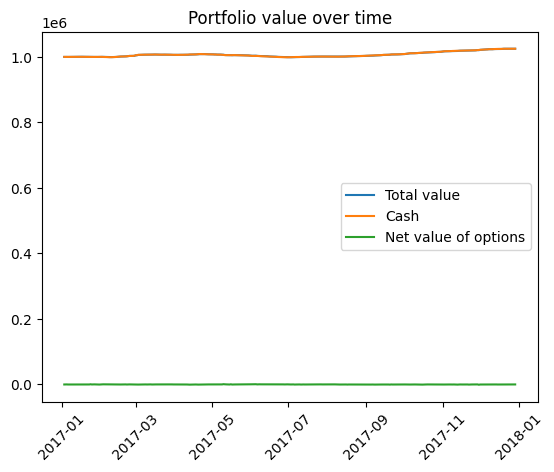

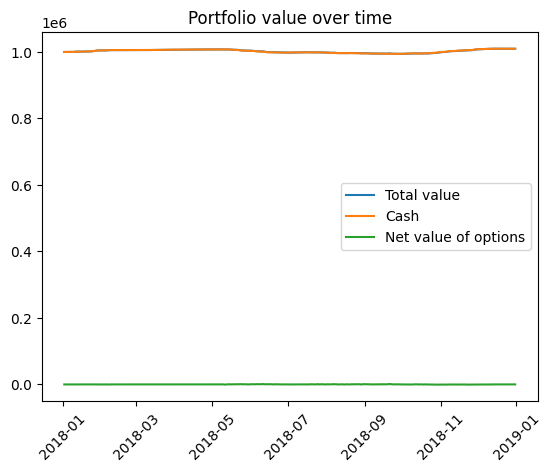

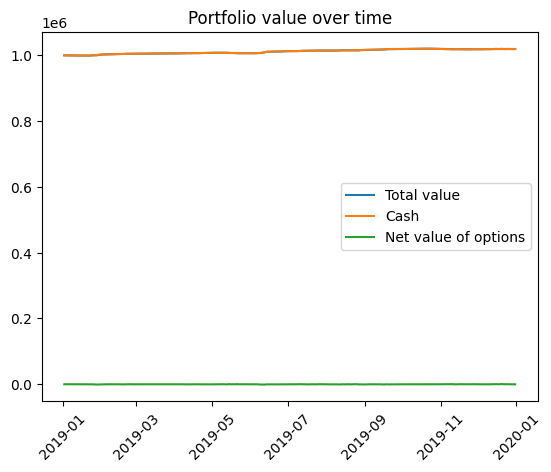

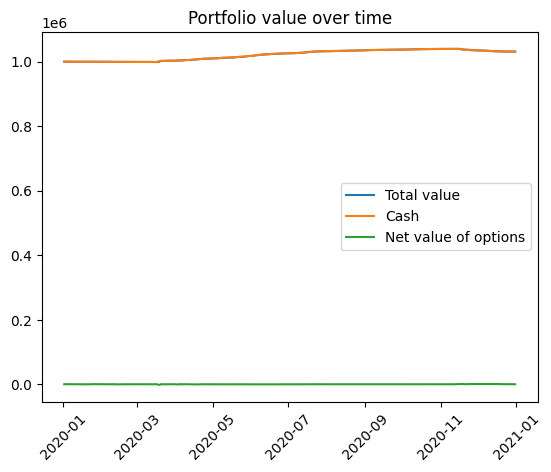

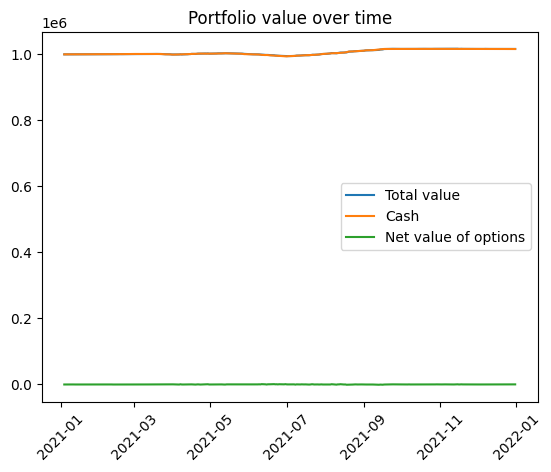

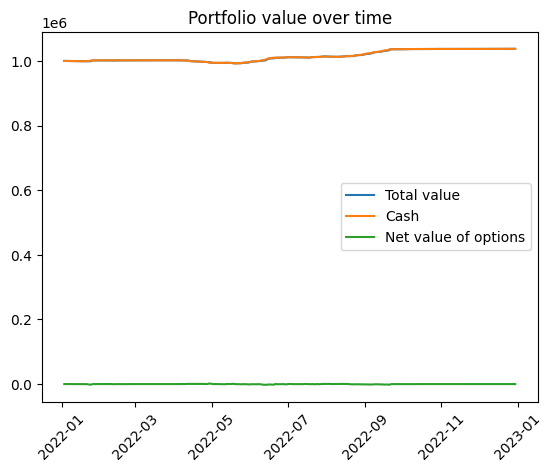

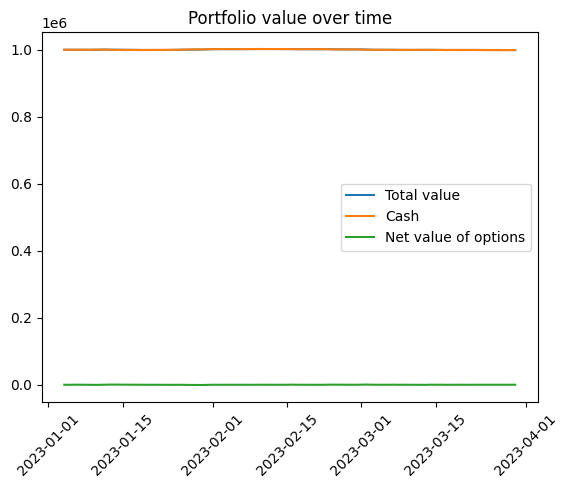

,Year,Starting balance,Ending balance,Profit,Profit per trade,Profit per trading day,Sharpe ratio,Sortino ratio,CAPM alpha,Annualized return in percent,Max drawdown
0,2015,1000000,1005510.0,5510.0,4.34,22.49,0.93,1.09,0.01,0.57,-0.70
1,2016,1000000,1009140.0,9140.0,9.86,36.56,0.42,0.45,0.01,0.92,-0.99
2,2017,1000000,1024977.0,24977.0,18.47,100.31,3.19,5.83,0.02,2.53,-0.96
3,2018,1000000,1009611.0,9611.0,3.57,38.29,-1.80,-2.49,0.01,0.97,-1.35
4,2019,1000000,1019156.0,19156.0,12.47,77.87,0.01,0.03,0.02,1.93,-0.22
5,2020,1000000,1031246.0,31246.0,11.77,125.48,6.93,12.49,0.03,3.13,-0.82
6,2021,1000000,1016171.0,16171.0,7.32,66.01,3.29,5.69,0.02,1.64,-0.91
7,2022,1000000,1037460.0,37460.0,7.56,146.90,3.64,8.01,0.04,3.79,-0.96
8,2023,1000000,999006.0,-994.0,-2.85,-16.84,-9.97,-13.69,-0.01,-0.43,-0.32


In [70]:
if run_optimizing == False:    
    # Initialize an empty DataFrame to store the results
    results = pd.DataFrame(columns=["Year", "Starting balance", "Ending balance", "Profit", "Profit per trade", "Profit per trading day", 
                                    "Sharpe ratio", "Sortino ratio", "CAPM alpha", "Annualized return in percent", "Max drawdown"])

    # Get the list of years present in the data
    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    years = df['Quote_date'].dt.year.unique()

    # Sort the years
    years.sort()

    total_dataframe_for_analysis = pd.DataFrame()
    # Iterate over each year
    for year in years:
        df_year = df[df['Quote_date'].dt.year == year].copy()
        
        if not df_year.empty:
            # Execute operations
            buy_signal, sell_signal = generate_buy_sell_signals(df_year, buy_sell_threshold, buy_sell_threshold)
            df_year = trader(df_year, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio, long_short_ratio)
            df_year = calculate_options_value(df_year)

            # Calculate metrics
            ending_balance = df_year['Balance'].iloc[-1]
            profit = ending_balance - starting_balance
            num_trades = df_year[df_year["Price"] > 1]["Signal"].abs().sum()
            profit_per_trade = profit / num_trades

            trading_days = df_year['Quote_date'].unique().shape[0] - 1
            profit_per_day = profit / trading_days
            num_days = (df_year['Quote_date'].max() - df_year['Quote_date'].min()).days

            annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

            plot(df_year)
            # Create a DataFrame for this year's metrics
            year_metrics = pd.DataFrame({
                "Year": [year], 
                "Starting balance": [starting_balance], 
                "Ending balance": [ending_balance.round(0)], 
                "Profit": [profit.round(0)], 
                "Profit per trade": [profit_per_trade.round(2)], 
                "Profit per trading day": [profit_per_day.round(2)],
                "Sharpe ratio": [sharpe_ratio(df_year).round(2)],
                "Sortino ratio": [sortino_ratio(df_year).round(2)], 
                "CAPM alpha": [capm_alpha(df_year).round(2)], 
                "Annualized return in percent": [annualized_return.round(2)], 
                "Max drawdown": [max_drawdown(df_year).round(2)]
            })
            # Add metrics to the results DataFrame
            results = pd.concat([results, year_metrics])

            total_dataframe_for_analysis = pd.concat([total_dataframe_for_analysis, df_year])

    # Reset index of the results DataFrame
    results.reset_index(drop=True, inplace=True)

    # Print the results DataFrame
    display(results)

In [71]:
# Drop 2023
results = results[results["Year"] != 2023]

# Add a final row to the results DataFrame with the average metrics
results.loc["Average"] = results.mean()

# Turn year, starting balance and ending balance, profit into integers
results[["Year", "Starting balance", "Ending balance", "Profit"]] = results[["Year", "Starting balance", "Ending balance", "Profit"]].astype(int)
#Remove profit per trad and profit per trading day
results = results.drop(columns=["Profit per trade", "Profit per trading day"])
# Rename the columns to  Year &  Starting &  Ending &  Profit &  Sharpe  &  alpha &  Return &  MDD \\
results.columns = ["Year", "Starting", "Ending", "Profit", "Sharpe", "Sortino", "alpha", "Return", "MDD"]
# Round to 2 decimals
float_cols = ["Sharpe", "alpha", "Return", "MDD"]
# Turn the columns into floats
results[float_cols] = results[float_cols].astype(float)

# Rename the columns to  Year &  Starting &  Ending &  Profit &  Sharpe  &  alpha &  Return &  MDD \\
results.columns = ["Year", "Starting", "Ending", "Profit", "Sharpe", "Sortino", "alpha", "Return", "MDD"]

results[float_cols] = results[float_cols].round(2)
print(results.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{rrrrrrrrr}
\toprule
Year & Starting & Ending & Profit & Sharpe & Sortino & alpha & Return & MDD \\
\midrule
2015 & 1000000 & 1005510 & 5510 & 0.93 & 1.09 & 0.01 & 0.57 & -0.70 \\
2016 & 1000000 & 1009140 & 9140 & 0.42 & 0.45 & 0.01 & 0.92 & -0.99 \\
2017 & 1000000 & 1024977 & 24977 & 3.19 & 5.83 & 0.02 & 2.53 & -0.96 \\
2018 & 1000000 & 1009611 & 9611 & -1.80 & -2.49 & 0.01 & 0.97 & -1.35 \\
2019 & 1000000 & 1019156 & 19156 & 0.01 & 0.03 & 0.02 & 1.93 & -0.22 \\
2020 & 1000000 & 1031246 & 31246 & 6.93 & 12.49 & 0.03 & 3.13 & -0.82 \\
2021 & 1000000 & 1016171 & 16171 & 3.29 & 5.69 & 0.02 & 1.64 & -0.91 \\
2022 & 1000000 & 1037460 & 37460 & 3.64 & 8.01 & 0.04 & 3.79 & -0.96 \\
2018 & 1000000 & 1019158 & 19158 & 2.08 & 3.89 & 0.02 & 1.93 & -0.86 \\
\bottomrule
\end{tabular}



## Trading behaviour analysis

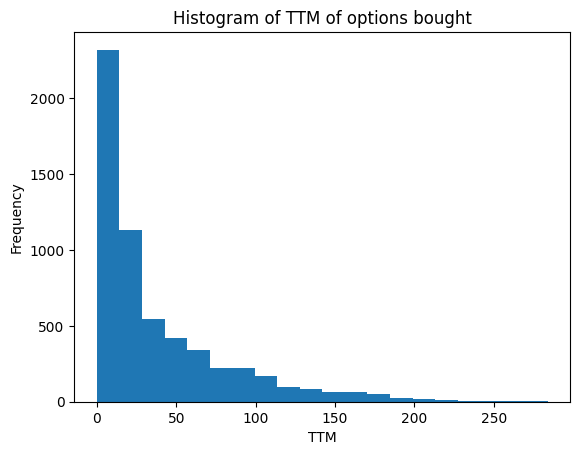

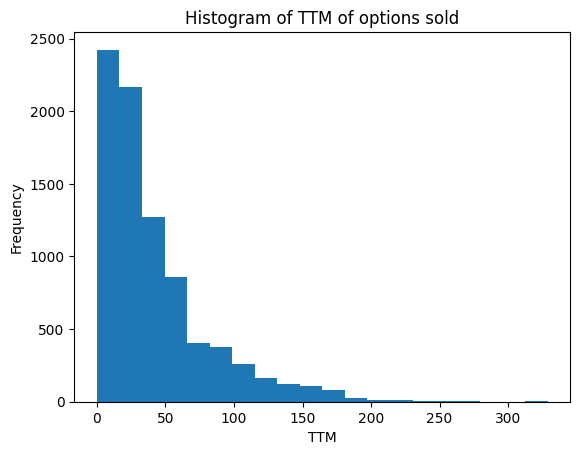

In [72]:
df_year_bought = total_dataframe_for_analysis[total_dataframe_for_analysis['Position_this_opt'] > 0]
df_year_sold = total_dataframe_for_analysis[total_dataframe_for_analysis['Position_this_opt'] < 0]

# Plot a histogram of the TTM of the options bought
plt.hist(df_year_bought['TTM'], bins=20)
plt.title('Histogram of TTM of options bought')
plt.xlabel('TTM')
plt.ylabel('Frequency')
plt.show()

# Plot a histogram of the TTM of the options sold
plt.hist(df_year_sold['TTM'], bins=20)
plt.title('Histogram of TTM of options sold')
plt.xlabel('TTM')
plt.ylabel('Frequency')
plt.show()

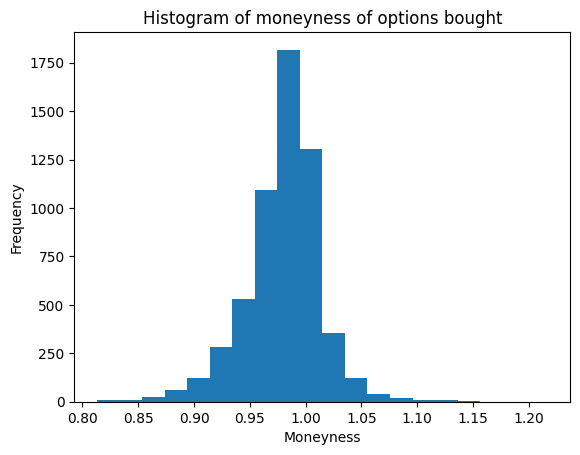

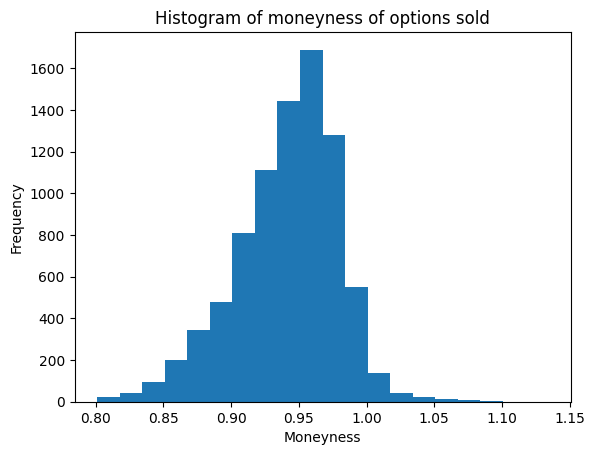

In [73]:
df_year_bought["Moneyness"] = df_year_bought["Underlying_last"] / df_year_bought["Strike"]
df_year_bought["Moneyness"] = df_year_bought["Moneyness"].round(3)

df_year_sold["Moneyness"] = df_year_sold["Underlying_last"] / df_year_sold["Strike"]
df_year_sold["Moneyness"] = df_year_sold["Moneyness"].round(3)

# Plot a histogram of the moneyness of the options bought
plt.hist(df_year_bought['Moneyness'], bins=20)
plt.title('Histogram of moneyness of options bought')
plt.xlabel('Moneyness')
plt.ylabel('Frequency')
plt.show()

# Plot a histogram of the moneyness of the options sold
plt.hist(df_year_sold['Moneyness'], bins=20)
plt.title('Histogram of moneyness of options sold')
plt.xlabel('Moneyness')
plt.ylabel('Frequency')
plt.show()


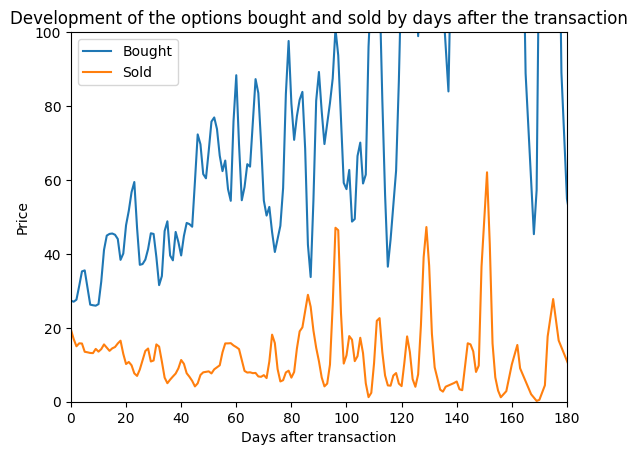

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# convert 'Quote_date' to datetime if it's not
df_year_bought["Quote_date"] = pd.to_datetime(df_year_bought["Quote_date"])
df_year_sold["Quote_date"] = pd.to_datetime(df_year_sold["Quote_date"])

groups_bought = df_year_bought.groupby("Option_ID")
groups_sold = df_year_sold.groupby("Option_ID")

for option_id, group in groups_bought:
    df_year_bought.loc[group.index, "Days after buy"] = (group["Quote_date"] - group["Quote_date"].iloc[0]).dt.days

for option_id, group in groups_sold:
    df_year_sold.loc[group.index, "Days after sell"] = (group["Quote_date"] - group["Quote_date"].iloc[0]).dt.days

# group by "Days after buy" / "Days after sell" and take the mean of the price for each day
df_days_after_buy = df_year_bought.groupby("Days after buy")["Price"].mean().reset_index()
df_days_after_sell = df_year_sold.groupby("Days after sell")["Price"].mean().reset_index()

# Apply gaussian filter
sigma = 1
df_days_after_buy["Price_smooth"] = gaussian_filter1d(df_days_after_buy["Price"], sigma)
df_days_after_sell["Price_smooth"] = gaussian_filter1d(df_days_after_sell["Price"], sigma)

# Plotting
plt.plot(df_days_after_buy["Days after buy"], df_days_after_buy["Price_smooth"], label='Bought')
plt.plot(df_days_after_sell["Days after sell"], df_days_after_sell["Price_smooth"], label='Sold')
plt.xlim(0, 180)
# Set suitable y lim based on the data
plt.ylim(0, 100)
plt.title('Development of the options bought and sold by days after the transaction')
plt.xlabel('Days after transaction')
plt.ylabel('Price')
plt.legend()
plt.show()


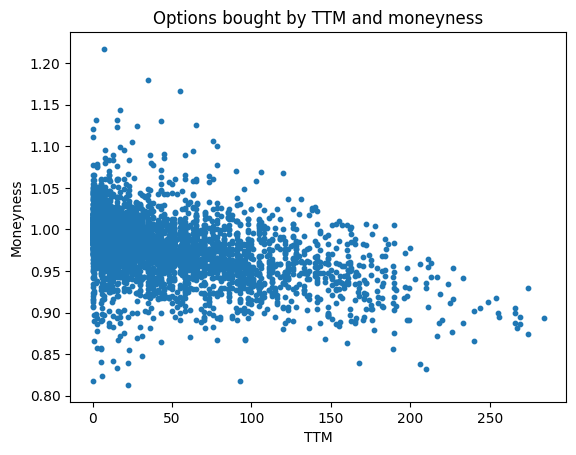

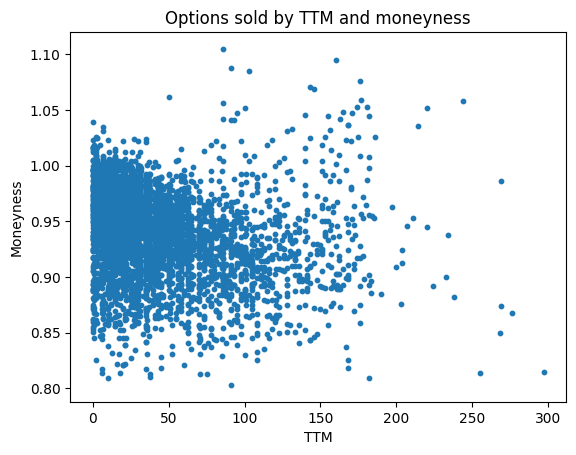

In [75]:
# Make 2d scatter plot of the options bought by TTM and moneyness
df_year_bought_sample = df_year_bought.sample(5000)
plt.scatter(df_year_bought_sample["TTM"], df_year_bought_sample["Moneyness"], s= 10)
plt.title('Options bought by TTM and moneyness')
plt.xlabel('TTM')
plt.ylabel('Moneyness')
plt.show()

# Make 2d scatter plot of the options sold by TTM and moneyness
df_year_sold_sample = df_year_sold.sample(5000)
plt.scatter(df_year_sold_sample["TTM"], df_year_sold_sample["Moneyness"], s= 10)
plt.title('Options sold by TTM and moneyness')
plt.xlabel('TTM')
plt.ylabel('Moneyness')
plt.show()

### Post analysis

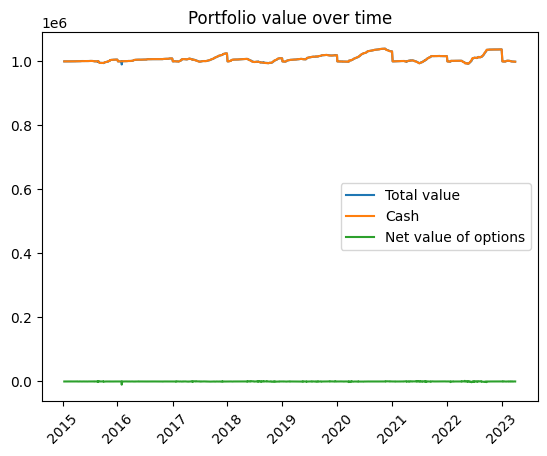

In [76]:
if run_optimizing == False:
    plot(total_dataframe_for_analysis)

## Threshold search

In [77]:
if run_optimizing:
    # Initialize wandb
    !pip install wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': '2015-2018 - v12',
    'metric': {
        'goal': 'maximize', 
        'name': 'alpha'
        },
    'parameters': {
        'buy_threshold': {
            'values': [0.06, 0.1, 0.12]},
        'sell_threshold': {
            'values': [0.06, 0.1, 0.12]},
        'price_cap_lower': {
            'values': [1, 2]},
        'investment_ratio': {
            'values': [5e-4, 5e-5, 5e-6]},
        'long_short_ratio': {
            'values': [0.05, 0.3]}
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


In [78]:
if run_optimizing:
    def find_best_thresholds(df = df):
        run = wandb.init(project = "options-trading")
        df = df.copy()
        buy_signal, sell_signal = generate_buy_sell_signals(df, run.config.buy_threshold, run.config.sell_threshold)
        df = trader(df, buy_signal, sell_signal, starting_balance=100000, price_cap_lower = run.config.price_cap_lower, investment_ratio = run.config.investment_ratio, long_short_ratio = run.config.long_short_ratio)
        df = calculate_options_value(df)
        run.log({"buy_threshold": run.config.buy_threshold, "sell_threshold": run.config.sell_threshold, "sharpe_ratio": sharpe_ratio_monthly(df), "ending_balance": df['Balance'].iloc[-1], "number_of_trades": df['Signal'].abs().sum(), "alpha": capm_alpha(df), "long_short_ratio": run.config.long_short_ratio, "price_cap_lower": run.config.price_cap_lower, "investment_ratio": run.config.investment_ratio})
        # Wandb callback
        print_results(df, 100000)
        plot(df)
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)